# Scribe: Realistic Handwriting with TensorFlow

### A deep learning project by Sam Greydanus. August 2016.

This iPython notebook simply explores how to load the handwriting dataset in preparation for training the model on real handwriting data.

First time use: download dataset from [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database). There are two folders in this dataset that matter: 'ascii' and 'lineStrokes'. Put these in a './data' directory relative to this notebook. When an instance of this model is created for the first time it will parse all of the xml data in these files and save a processed version to a pickle file. This takes about 10 minutes but you only need to do it once

I took some of the code for this class from **hardmaru**'s [write-rnn-tensorflow](https://github.com/hardmaru/write-rnn-tensorflow) project and modified it to return the ascii labels in addition to the pen stroke data.

In [10]:
import os
import _pickle as cPickle
import numpy as np
import xml.etree.ElementTree as ET
import random
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

## Define the data loader class

This class is almost identical to the one I used to train the handwriting model

In [11]:
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "rb") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        cPickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = cPickle.load(f,encoding='bytes')
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print("Loaded dataset:")
        print("   -> {} individual data points".format(len(self.stroke_data)))
        print("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        s = s.decode('utf8')
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print("pointer reset")

## Build data loader

In [13]:
batch_size = 5
tsteps = 700
data_scale = 50
U_items = int(tsteps/20)
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, \
                         scale_factor=data_scale, U_items=U_items, alphabet="default")

Loaded dataset:
   -> 3927 individual data points
   -> 785 batches
pointer reset


## Display a subset of the data

In [14]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

5


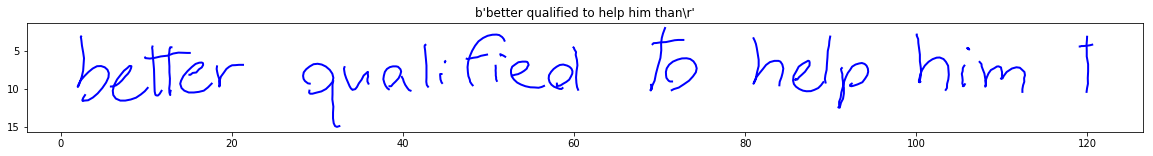

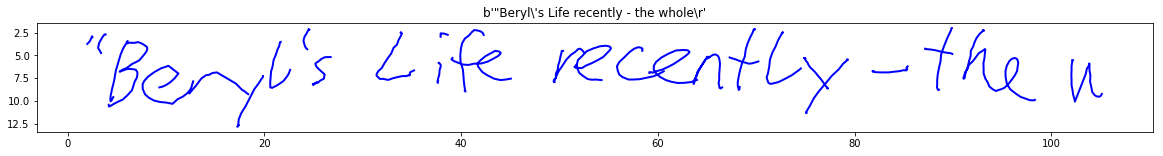

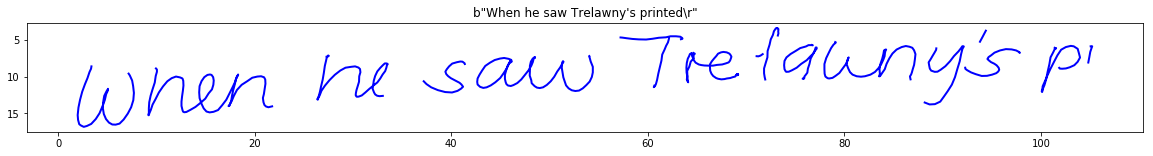

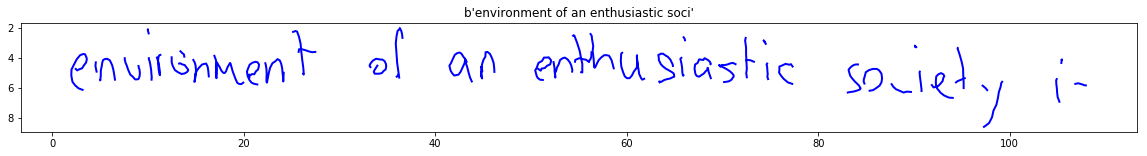

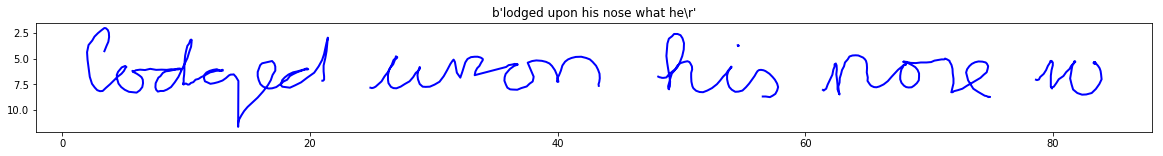

In [15]:
x, y, s, c = data_loader.next_batch()
print(data_loader.pointer)
for i in range(batch_size):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])

## Stroke styles

These are the five handwriting styles from the blog post. In the future, I will use them to "prime" my model so that it will synthesize handwriting in a particular style

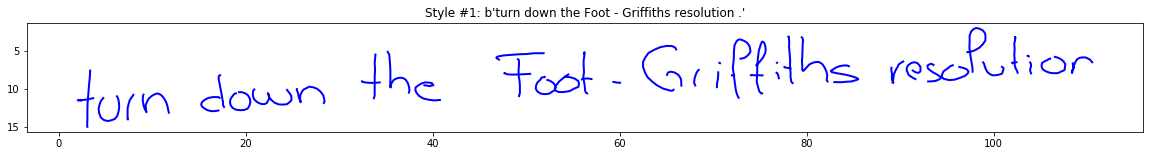

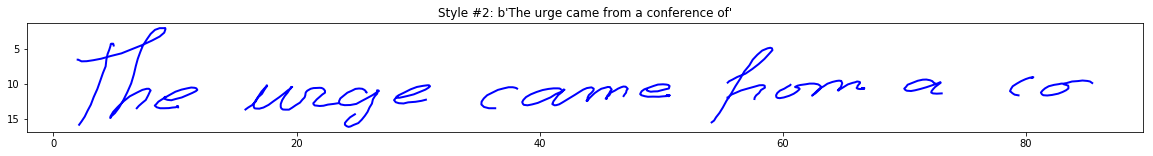

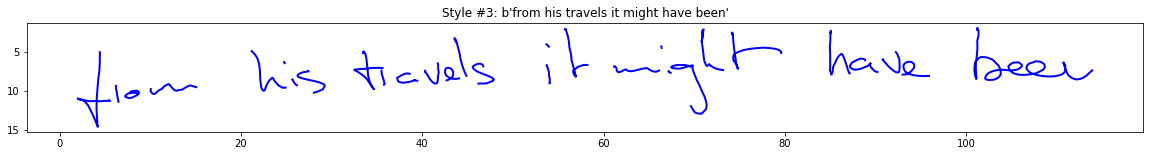

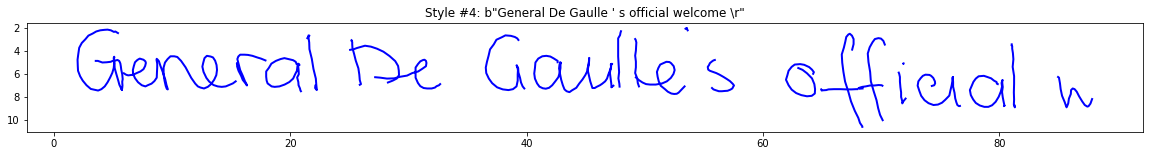

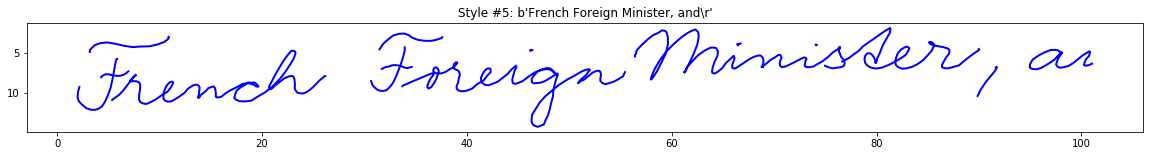

In [16]:
with open(os.path.join('data', 'styles.p'),'rb') as f:
    style_strokes, style_strings = cPickle.load(f,encoding='bytes')
    
for i in range(len(style_strokes)):
    strokes = style_strokes[i]
    strokes[:,:-1] = np.cumsum(strokes[:,:-1], axis=0)
    line_plot(strokes, "Style #{}: {}".format(i+1, style_strings[i]))

In [17]:
from model import *
import time

# Model parameters
class Param():
    def __init__(self):
        # General parameters
        self.train = 1 # Train the model
        self.sample = 0 # Sample from the model
        self.rnn_size =100 # Size of RNN hidden state
        self.tsteps =150 # RNN time steps (for backprop)
        self.nmixtures =8 # Number of gaussian mixtures

        # Training parameters
        self.batch_size = 32 # Batch size for each gradient step
        self.nbatches = 500 # Number of batches per epoch, default is 500
        self.nepochs = 250 # Number of epochs, default is 250
        self.dropout = 0.85 # Probability of keeping neuron during dropout
        self.grad_clip = 10. # Clip gradients to this magnitude
        self.optimizer = 'rmsprop' # Ctype of optimizer: 'rmsprop' or 'adam'
        self.learning_rate = 1e-4 # Learning rate
        self.lr_decay = 0.95 # Decay rate for learning rate
        self.decay = 0.95 # Decay rate for rmsprop
        self.momentum = 0.9 # Momentum for rmsprop

        # Window parmaters
        self.kmixtures = 1 # Number of gaussian mixtures for character window
        self.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' # Default is a-z, A-Z, space, and <UNK> tag
        self.tsteps_per_ascii = 25 # Expected number of pen points per character

        # Book-saving
        self.data_scale = 50 # Amount to scale data down before training
        self.log_dir ='./logs/' # Location, relative to execution, of log files
        self.data_dir ='./data' # Location, relative to execution, of data
        self.save_path ='saved/model.ckpt' # Location to save model
        self.save_every = 500 # Number of batches between each save

        # Sampling
        self.text ='' # String for sampling model (defaults to test cases)
        self.style =-1 # Optionally condition model on a preset style (using data in styles.p)
        self.bias = 1.0 # Higher bias means neater, lower means more diverse (range is 0-5)
        self.sleep_time=60*5 # Time to sleep between running sampler
        
args = Param()

In [18]:
# Training the model

logger = Logger(args) # make logging utility
logger.write("\nTRAINING MODE...")
logger.write("{}\n".format(args))
logger.write("loading data...")
data_loader = DataLoader(args, logger=logger)

logger.write("building model...")
model = Model(args, logger=logger)



TRAINING MODE...

loading data...
	loaded dataset:
		11315 train individual data points
		595 valid individual data points
		353 batches
building model...
	using alphabet abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


ValueError: Variable cell0/lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\Alang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Users\Alang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\Alang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [ ]:
logger.write("attempt to load saved model...")
load_was_success, global_step = model.try_load_model(args.save_path)

v_x, v_y, v_s, v_c = data_loader.validation_data()
valid_inputs = {model.input_data: v_x, model.target_data: v_y, model.char_seq: v_c}

logger.write("training...")
model.sess.run(tf.assign(model.decay, args.decay ))
model.sess.run(tf.assign(model.momentum, args.momentum ))
running_average = 0.0 ; remember_rate = 0.99
for e in range(int(global_step/args.nbatches), args.nepochs):
    model.sess.run(tf.assign(model.learning_rate, args.learning_rate * (args.lr_decay ** e)))
    #logger.write("learning rate: {}".format(model.learning_rate.eval()))

    c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
    h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
    kappa = np.zeros((args.batch_size, args.kmixtures, 1))

    for b in range(global_step%args.nbatches, args.nbatches):

        i = e * args.nbatches + b
        if global_step is not 0 : i+=1 ; global_step = 0

        if i % args.save_every == 0 and (i > 0):
            model.saver.save(model.sess, args.save_path, global_step = i) ; logger.write('SAVED MODEL')

        start = time.time()
        x, y, s, c = data_loader.next_batch()

        feed = {model.input_data: x, model.target_data: y, model.char_seq: c, model.init_kappa: kappa, \
            model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
            model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}

        [train_loss, _] = model.sess.run([model.cost, model.train_op], feed)
        feed.update(valid_inputs)
        feed[model.init_kappa] = np.zeros((args.batch_size, args.kmixtures, 1))
        [valid_loss] = model.sess.run([model.cost], feed)

        running_average = running_average*remember_rate + train_loss*(1-remember_rate)

        end = time.time()
        if i % 10 is 0: logger.write("{}/{}, loss = {:.3f}, regloss = {:.5f}, valid_loss = {:.3f}, time = {:.3f}" \
            .format(i, args.nepochs * args.nbatches, train_loss, running_average, valid_loss, end - start))

attempt to load saved model...
INFO:tensorflow:Restoring parameters from saved\model.ckpt-18200
loaded model: saved\model.ckpt-18200
training...
18210/125000, loss = 1.198, regloss = 0.20734, valid_loss = 0.980, time = 0.719
18220/125000, loss = 0.161, regloss = 0.24106, valid_loss = 0.153, time = 0.719
18230/125000, loss = -0.184, regloss = 0.21277, valid_loss = -0.170, time = 0.672
18240/125000, loss = -0.355, regloss = 0.15979, valid_loss = -0.392, time = 0.703
18250/125000, loss = -0.596, regloss = 0.09235, valid_loss = -0.568, time = 0.781
18260/125000, loss = -0.717, regloss = 0.01947, valid_loss = -0.689, time = 0.703
18270/125000, loss = -0.879, regloss = -0.05223, valid_loss = -0.781, time = 0.703
18280/125000, loss = -0.901, regloss = -0.13161, valid_loss = -0.830, time = 0.703
18290/125000, loss = -1.032, regloss = -0.21126, valid_loss = -0.894, time = 0.719
18300/125000, loss = -1.035, regloss = -0.28893, valid_loss = -0.971, time = 0.703
18310/125000, loss = -1.031, reglos